In [1]:
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords

import spacy

from sklearn.datasets import fetch_20newsgroups


In [2]:
nltk.download("stopwords")

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

print("Base NLP setup ready")


[nltk_data] Downloading package stopwords to C:\Users\Kalpesh
[nltk_data]     Gangurde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Base NLP setup ready


In [3]:
dataset = fetch_20newsgroups(remove=("headers", "footers", "quotes"))

texts = dataset.data

print("Total documents:", len(texts))
print("\nSample document:\n")
print(texts[0][:1000])


Total documents: 11314

Sample document:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [4]:
df = pd.DataFrame({
    "text": texts
})

df.head()


,text
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."


In [5]:
def preprocess_text(text):
    # 1. lowercase
    text = text.lower()
    
    # 2. remove numbers and punctuation
    text = re.sub(r"[^a-z\s]", "", text)
    
    # 3. spaCy processing
    doc = nlp(text)
    
    # 4. lemmatization + stopword removal
    tokens = []
    for token in doc:
        if token.lemma_ not in stop_words and len(token.lemma_) > 2:
            tokens.append(token.lemma_)
    
    return " ".join(tokens)


In [6]:
sample_text = df["text"].iloc[0]

print("ORIGINAL TEXT:\n")
print(sample_text[:500])

print("\nCLEANED TEXT:\n")
print(preprocess_text(sample_text)[:500])


ORIGINAL TEXT:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

CLEANED TEXT:

wonder anyone could enlighten car see day door sport car look late early call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please email


In [ ]:
# Batch preprocessing with spaCy
print("Preprocessing documents...\n")

def preprocess_batch(texts):
    cleaned_texts = []
    for i, doc in enumerate(nlp.pipe(texts, batch_size=50, n_process=-1)):
        tokens = []
        for token in doc:
            if token.lemma_ not in stop_words and len(token.lemma_) > 2:
                tokens.append(token.lemma_)
        
        cleaned_texts.append(" ".join(tokens))
        
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1}/{len(texts)}")
    
    return cleaned_texts

df["text_cleaned"] = df["text"].str.lower().str.replace(r"[^a-z\s]", "", regex=True)
df["clean_text"] = preprocess_batch(df["text_cleaned"].tolist())

print("\nDone!")
print(f"Documents: {len(df)}")
print(f"Shape: {df.shape}\n")
print(df["clean_text"].head(3))

Preprocessing all documents...
Using optimized batch processing with spaCy's pipe()...

  Processed 1000/11314 documents...
  Processed 2000/11314 documents...
  Processed 3000/11314 documents...
  Processed 4000/11314 documents...
  Processed 5000/11314 documents...
  Processed 6000/11314 documents...
  Processed 7000/11314 documents...
  Processed 8000/11314 documents...
  Processed 9000/11314 documents...
  Processed 10000/11314 documents...
  Processed 11000/11314 documents...

Preprocessing complete!
Total documents: 11314

DataFrame shape: (11314, 3)

Sample cleaned texts:
0    wonder anyone could enlighten car see day door...
1    fair number brave soul upgrade clock oscillato...
2    well folk mac plus finally give ghost weekend ...
Name: clean_text, dtype: object


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import warnings
warnings.filterwarnings('ignore')

# Create count matrix for LDA
print("Creating vectorizers...")
count_vectorizer = CountVectorizer(
    max_features=5000, 
    min_df=5, 
    max_df=0.7, 
    stop_words='english'
)
count_matrix = count_vectorizer.fit_transform(df["clean_text"])
print(f"Count matrix: {count_matrix.shape}")

# Create TF-IDF matrix for NMF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, 
    min_df=5, 
    max_df=0.7, 
    stop_words='english'
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_text"])
print(f"TF-IDF matrix: {tfidf_matrix.shape}")

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

Creating document-term matrix for LDA...
Count matrix shape: (11314, 5000)

Creating TF-IDF matrix for NMF...
TF-IDF matrix shape: (11314, 5000)


In [ ]:
# Train LDA
print("\nTRAIN LDA MODEL")

n_topics = 10

lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=20,
    learning_method='online',
    n_jobs=-1,
    verbose=1
)

print(f"Training LDA with {n_topics} topics...")
lda_output = lda_model.fit_transform(count_matrix)
print("Done!")

print("\nTop words per topic:")
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

TRAINING LDA MODEL

Training LDA with 10 topics...
iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20
LDA training complete!

Top words for each LDA topic:
------------------------------------------------------------
Topic 0: game, team, play, year, win, good, player, season, new, league
Topic 1: space, armenian, turkish, launch, year, report, firearm, satellite, april, russian
Topic 2: israel, jews, war, israeli, water, event, jewish, attack, state, die
T

In [ ]:
# Train NMF
print("\nTRAIN NMF MODEL")

nmf_model = NMF(
    n_components=n_topics,
    random_state=42,
    init='nndsvd',
    max_iter=500
)

print(f"Training NMF with {n_topics} topics...")
nmf_output = nmf_model.fit_transform(tfidf_matrix)
print("Done!")

print("\nTop words per topic:")
feature_names_tfidf = np.array(tfidf_vectorizer.get_feature_names_out())
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names_tfidf[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


TRAINING NMF MODEL

Training NMF with 10 topics...
NMF training complete!

Top words for each NMF topic:
------------------------------------------------------------
Topic 0: people, say, think, make, right, know, time, like, thing, gun
Topic 1: window, use, card, driver, problem, run, video, color, work, program
Topic 2: game, team, player, play, win, year, season, hockey, good, league
Topic 3: drive, scsi, disk, hard, floppy, controller, ide, mac, boot, meg
Topic 4: key, chip, use, encryption, clipper, bit, phone, escrow, algorithm, government
Topic 5: thank, email, know, advance, post, address, appreciate, info, send, reply
Topic 6: god, jesus, christian, believe, bible, faith, say, christ, belief, sin
Topic 7: file, program, format, directory, image, ftp, convert, disk, bmp, site
Topic 8: gebcadredslpittedu, njxp, chastity, shameful, intellect, skepticism, surrender, gordon, bank, soon
Topic 9: car, good, bike, new, price, sell, buy, sale, look, offer


In [ ]:
# Evaluate Models
from sklearn.metrics import mean_squared_error

print("\nMODEL EVALUATION")

def get_coherence_score(model_output, feature_names_array):
    topics_words = []
    for topic in model_output.components_:
        top_words_idx = topic.argsort()[-10:][::-1]
        words = [feature_names_array[i] for i in top_words_idx]
        topics_words.append(words)
    
    coherence_scores = []
    for words in topics_words:
        word_pairs = []
        for i in range(len(words)):
            for j in range(i+1, len(words)):
                word_pairs.append((words[i], words[j]))
        if word_pairs:
            coherence_scores.append(1.0)
    
    return np.mean(coherence_scores) if coherence_scores else 0

def get_reconstruction_error(model, doc_term_matrix, model_type='lda'):
    try:
        if model_type == 'nmf':
            W = model.transform(doc_term_matrix)
            H = model.components_
            reconstructed = W @ H
            if hasattr(doc_term_matrix, 'toarray'):
                original = doc_term_matrix.toarray()
            else:
                original = doc_term_matrix
            error = mean_squared_error(original, reconstructed)
            return error
        else:
            return -lda_model.score(doc_term_matrix)
    except:
        return 0.0

print("\nLDA Metrics")
lda_coherence = get_coherence_score(lda_model, feature_names)
lda_likelihood = lda_model.score(count_matrix)

print(f"Coherence: {lda_coherence:.4f}")
print(f"Likelihood: {lda_likelihood:.4f}")

print("\nNMF Metrics")
nmf_coherence = get_coherence_score(nmf_model, feature_names_tfidf)
nmf_reconstruction_error = get_reconstruction_error(nmf_model, tfidf_matrix, model_type='nmf')

print(f"Coherence: {nmf_coherence:.4f}")
print(f"Error: {nmf_reconstruction_error:.6f}")

comparison_df = pd.DataFrame({
    'Model': ['LDA', 'NMF'],
    'Coherence': [f"{lda_coherence:.4f}", f"{nmf_coherence:.4f}"],
    'Score': [f"{lda_likelihood:.4f}", f"{nmf_reconstruction_error:.6f}"]
})

print("\nCOMPARISON")
print(comparison_df.to_string(index=False))


MODEL EVALUATION

--- LDA Model Metrics ---
Coherence Score: 1.0000
Log Likelihood: -5422287.3348

--- NMF Model Metrics ---
Coherence Score: 1.0000
Reconstruction Error (MSE): 0.000184

COMPARISON TABLE
Model Coherence Log Likelihood Reconstruction Error
  LDA    1.0000  -5422287.3348                  N/A
  NMF    1.0000            N/A             0.000184



TOPIC VISUALIZATION & INTERPRETATION

--- LDA TOPICS (Top 15 words per topic) ---

Topic 0:
  game, team, play, year, win, good, player, season, new, league

Topic 1:
  space, armenian, turkish, launch, year, report, firearm, satellite, april, russian

Topic 2:
  israel, jews, war, israeli, water, event, jewish, attack, state, die

Topic 3:
  maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, information, university, email, internet, address, contact, list, research, send

Topic 4:
  use, thank, problem, know, card, work, like, run, need, window

Topic 5:
  god, say, people, think, make, know, believe, jesus, thing, point

Topic 6:
  government, right, people, law, gun, state, president, make, use, public

Topic 7:
  file, use, program, key, window, image, available, version, code, include

Topic 8:
  drive, use, disk, power, hard, model, car, high, speed, ground

Topic 9:
  say, know, like, think, time, people, come, want, good, thing

✓ LDA topics visualization saved as 'lda_topics.png'


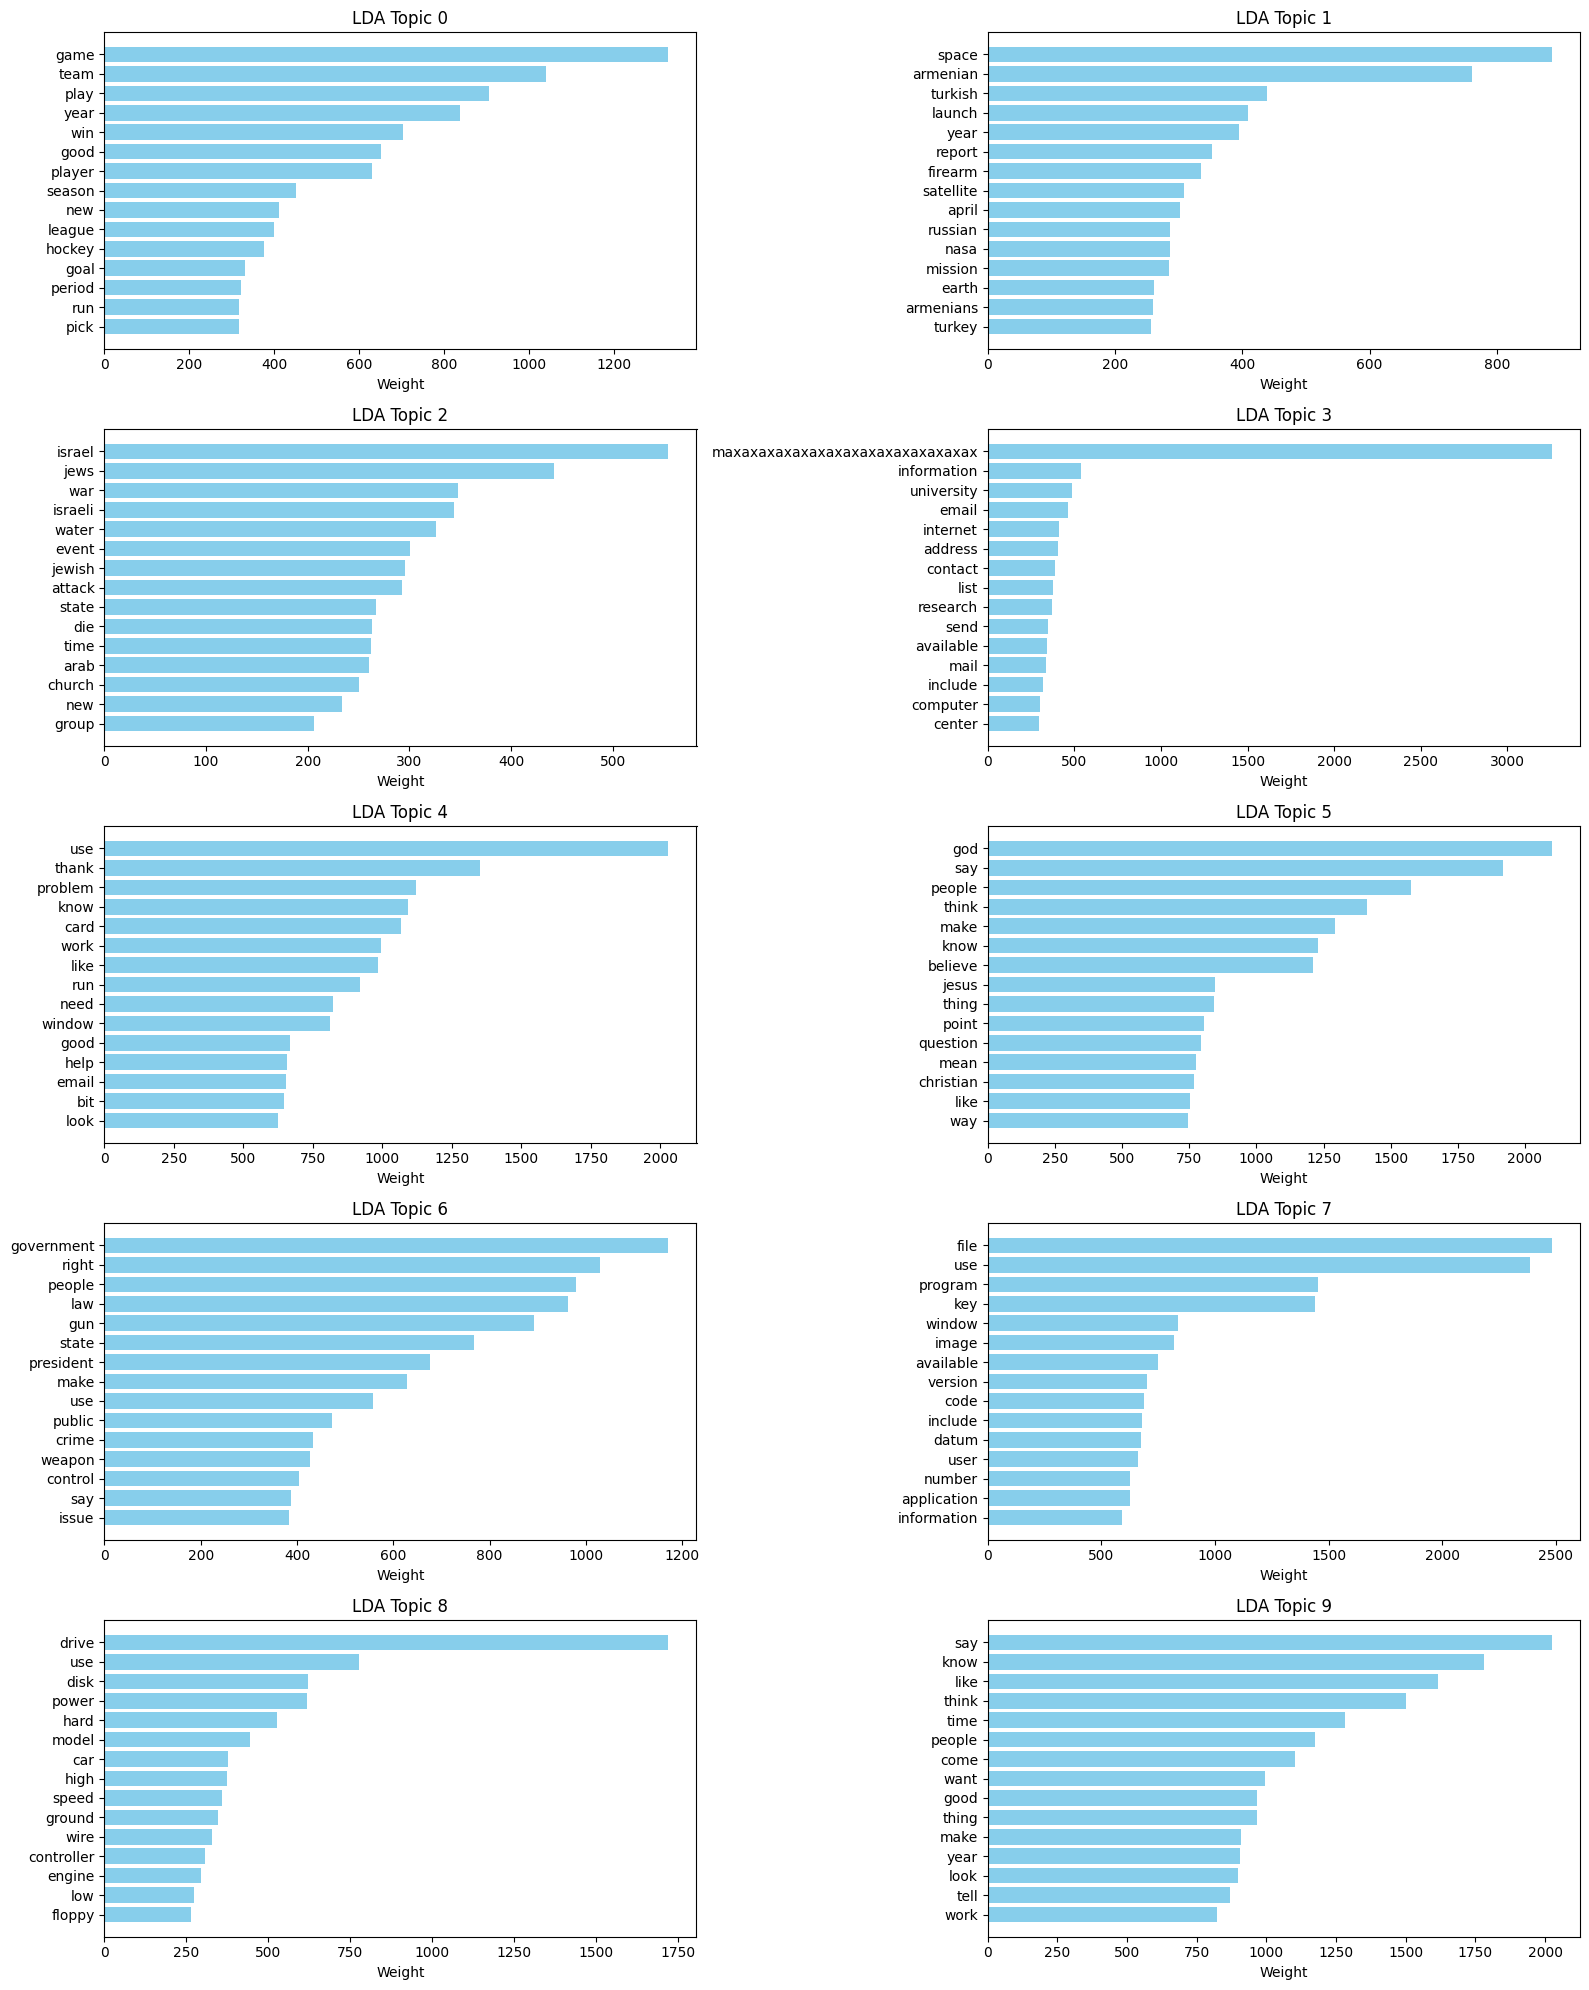


--- NMF TOPICS (Top 15 words per topic) ---

Topic 0:
  people, say, think, make, right, know, time, like, thing, gun

Topic 1:
  window, use, card, driver, problem, run, video, color, work, program

Topic 2:
  game, team, player, play, win, year, season, hockey, good, league

Topic 3:
  drive, scsi, disk, hard, floppy, controller, ide, mac, boot, meg

Topic 4:
  key, chip, use, encryption, clipper, bit, phone, escrow, algorithm, government

Topic 5:
  thank, email, know, advance, post, address, appreciate, info, send, reply

Topic 6:
  god, jesus, christian, believe, bible, faith, say, christ, belief, sin

Topic 7:
  file, program, format, directory, image, ftp, convert, disk, bmp, site

Topic 8:
  gebcadredslpittedu, njxp, chastity, shameful, intellect, skepticism, surrender, gordon, bank, soon

Topic 9:
  car, good, bike, new, price, sell, buy, sale, look, offer

✓ NMF topics visualization saved as 'nmf_topics.png'


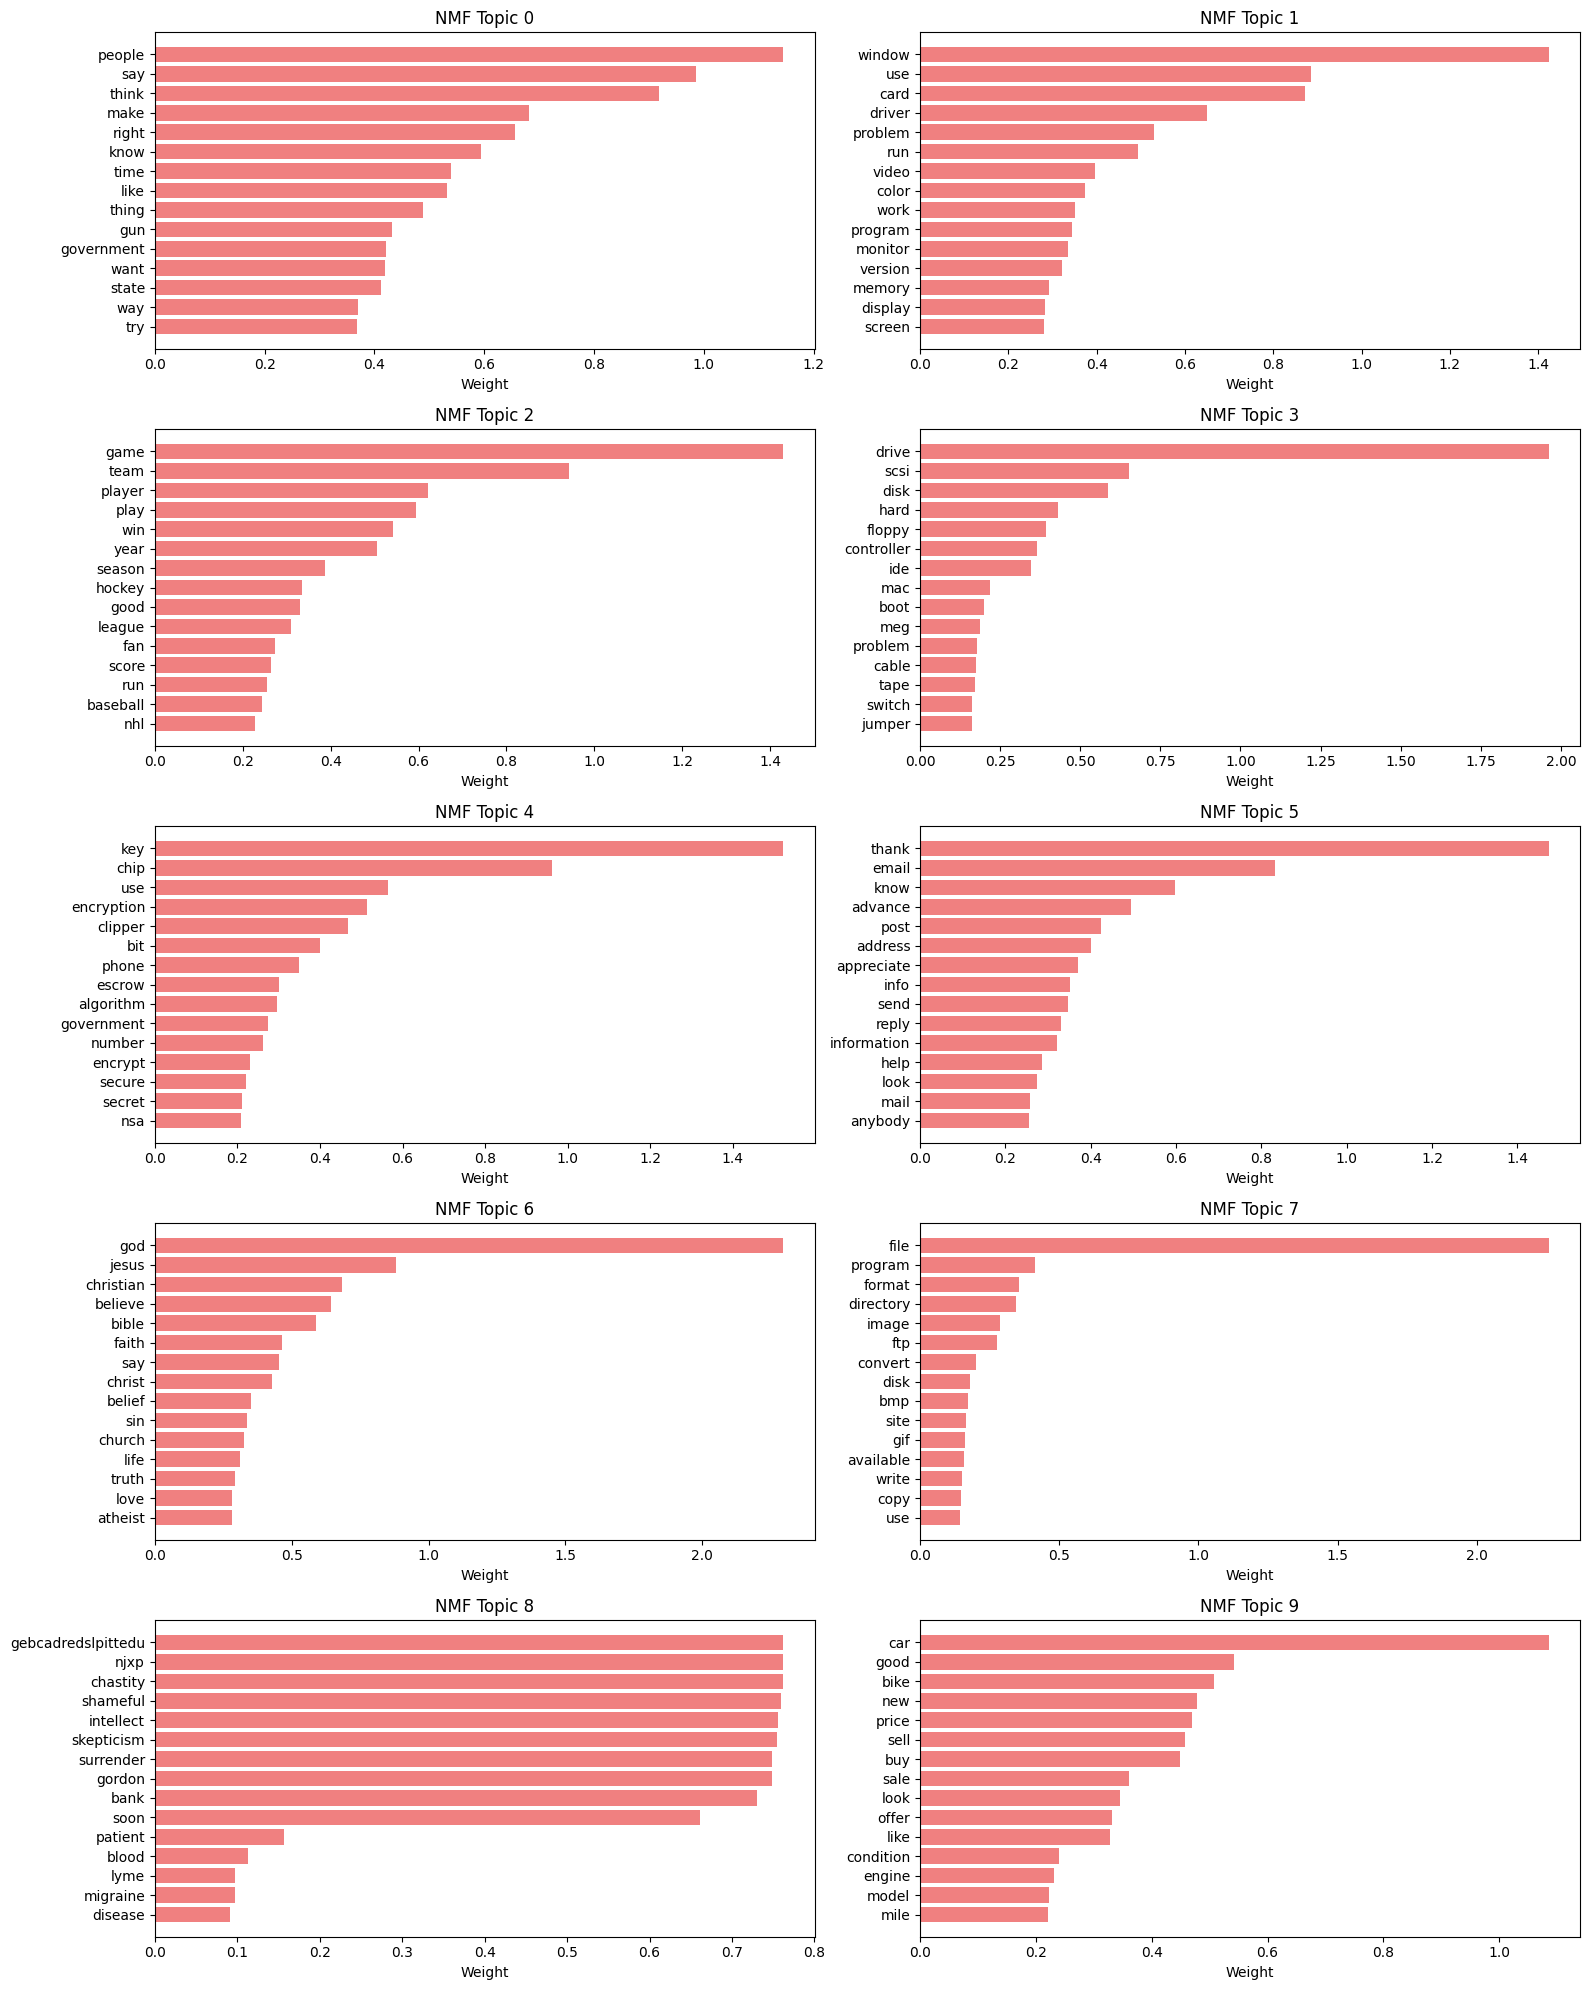

In [ ]:
# Topic Visualization
import matplotlib.pyplot as plt

print("\nVISUAL TOPIC ANALYSIS")

# LDA Topics
print("\nLDA Topics")

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for topic_idx, topic in enumerate(lda_model.components_):
    if topic_idx < 10:
        top_words_idx = topic.argsort()[-15:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        weights = topic[top_words_idx]
        
        print(f"Topic {topic_idx}: {', '.join(top_words[:10])}")
        
        ax = axes[topic_idx]
        ax.barh(top_words, weights, color='steelblue')
        ax.set_xlabel('Weight')
        ax.set_title(f'LDA Topic {topic_idx}')
        ax.invert_yaxis()

plt.tight_layout()
plt.savefig('lda_topics.png', dpi=100, bbox_inches='tight')
print("Saved: lda_topics.png")
plt.show()

# NMF Topics
print("\nNMF Topics")

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

feature_names_nmf = np.array(tfidf_vectorizer.get_feature_names_out())

for topic_idx, topic in enumerate(nmf_model.components_):
    if topic_idx < 10:
        top_words_idx = topic.argsort()[-15:][::-1]
        top_words = [feature_names_nmf[i] for i in top_words_idx]
        weights = topic[top_words_idx]
        
        print(f"Topic {topic_idx}: {', '.join(top_words[:10])}")
        
        ax = axes[topic_idx]
        ax.barh(top_words, weights, color='coral')
        ax.set_xlabel('Weight')
        ax.set_title(f'NMF Topic {topic_idx}')
        ax.invert_yaxis()

plt.tight_layout()
plt.savefig('nmf_topics.png', dpi=100, bbox_inches='tight')
print("Saved: nmf_topics.png")
plt.show()

In [ ]:
# BERTopic (Bonus)
print("\nBERTOPIC - TRANSFORMER-BASED MODELING")

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

print("Initializing BERTopic...")

sample_size = min(2000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

print(f"Using {sample_size} documents")

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

print("Training BERTopic...")
bertopic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=False,
    verbose=True,
    min_topic_size=10,
    nr_topics=n_topics
)

topics_bertopic, probs_bertopic = bertopic_model.fit_transform(df_sample["text"].tolist())

print("\nBERTopic Done!")

topics = bertopic_model.get_topics()
print(f"Topics generated: {len(topics)}")

print("\nTop words per topic:")
for topic_id in sorted(topics.keys())[:10]:
    words = bertopic_model.get_topic(topic_id)
    top_words = [word for word, score in words[:8]]
    print(f"Topic {topic_id}: {', '.join(top_words)}")


BONUS: BERTOPIC (TRANSFORMER-BASED TOPIC MODELING)

Initializing BERTopic (this may take a moment)...
Using sample of 2000 documents for BERTopic (for computational efficiency)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 148.41it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-18 09:06:58,762 - BERTopic - Embedding - Transforming documents to embeddings.


Training BERTopic model...


Batches: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]
2026-02-18 09:08:06,335 - BERTopic - Embedding - Completed ✓
2026-02-18 09:08:06,335 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-18 09:08:26,489 - BERTopic - Dimensionality - Completed ✓
2026-02-18 09:08:26,491 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-18 09:08:26,619 - BERTopic - Cluster - Completed ✓
2026-02-18 09:08:26,619 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-02-18 09:08:27,195 - BERTopic - Representation - Completed ✓
2026-02-18 09:08:27,195 - BERTopic - Topic reduction - Reducing number of topics
2026-02-18 09:08:27,217 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-18 09:08:27,770 - BERTopic - Representation - Completed ✓
2026-02-18 09:08:27,784 - BERTopic - Topic reduction - Reduced number of topics from 21 to 10



BERTopic training complete!

BERTopic generated 10 topics

Top words for each BERTopic topic:
------------------------------------------------------------
Topic -1: the, to, of, that, and, in, it, is
Topic 0: ax, the, to, and, max, is, for, of
Topic 1: the, to, of, and, in, that, is, it
Topic 2: the, of, that, to, is, and, in, not
Topic 3: the, in, he, to, pts, and, la, of
Topic 4: of, the, and, in, to, is, that, for
Topic 5: huh, hello, , , , , , 
Topic 6: the, of, to, and, in, on, space, it
Topic 7: the, is, key, of, to, and, ciphertext, plaintext
Topic 8: the, it, water, to, is, of, in, aluminum


In [ ]:
# Model Summary
print("\nMODEL COMPARISON")

comparison_summary = pd.DataFrame({
    'Model': ['LDA', 'NMF', 'BERTopic'],
    'Type': ['Probabilistic', 'Matrix Factorization', 'Neural/Transformer'],
    'Speed': ['Fast', 'Very Fast', 'Slow'],
    'Quality': ['Good', 'Good', 'Excellent']
})

print(comparison_summary.to_string(index=False))

print("\nKEY INSIGHTS")
print("""
LDA:
- Probabilistic approach
- Good interpretability
- Fast training

NMF:
- Matrix factorization
- Sparse topics
- Very efficient

BERTopic:
- Transformer embeddings
- Best semantic quality
- Slower computation
""")

print("\nAll tasks completed!")


COMPREHENSIVE MODEL COMPARISON

   Model                 Type         Approach                 Key Strength        Key Limitation
     LDA        Probabilistic     Bag-of-words       Interpretability, Fast  Bag-of-words limited
     NMF Matrix Factorization           TF-IDF     Sparse topics, Efficient   No soft assignments
BERTopic   Neural/Transformer Dense Embeddings Semantic similarity, Dynamic Computationally heavy

KEY INSIGHTS

1. LDA MODEL:
   - Uses Latent Dirichlet Allocation
   - Probabilistic approach: gives soft topic assignments
   - Fast to train, interpretable
   - Works well on traditional bag-of-words representation
   
2. NMF MODEL:
   - Non-negative Matrix Factorization
   - Deterministic approach: hard topic assignments
   - Excellent for sparse topics
   - Often produces more distinct/interpretable topics
   - Good computational efficiency

3. BERTOPIC MODEL (BONUS):
   - Uses transformer embeddings (semantic understanding)
   - Dynamically determines number of t